In [3]:
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

cifar10_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
cifar10_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


In [14]:
cifar10_valset, cifar10_testset = torch.utils.data.random_split(
    cifar10_testset, [int(0.9 * len(cifar10_testset)), int(0.1 * len(cifar10_testset))]
)

train_dataloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(cifar10_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(cifar10_trainset))
print("Validation dataset size: ", len(cifar10_valset))
print("Testing dataset size: ", len(cifar10_testset))

Training dataset size:  50000
Validation dataset size:  900
Testing dataset size:  100


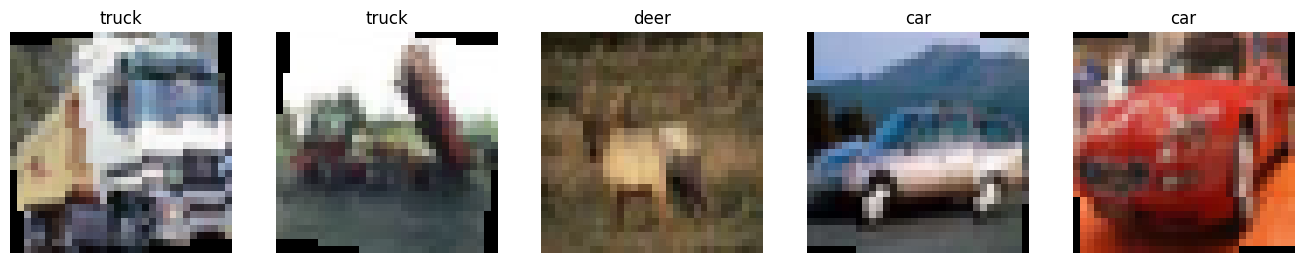

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Visualize data
fig = plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img_tensor = cifar10_trainset[i][0]
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    img_tensor = img_tensor * std + mean
    img_tensor = torch.clamp(img_tensor, 0, 1)

    img = transforms.ToPILImage()(img_tensor)
    fig.add_subplot(1, 6, i)
    plt.title(f"{classes[cifar10_trainset[i][1]]}")
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [7]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn_1 = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn_2 = nn.BatchNorm2d(64)
        self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn_3 = nn.BatchNorm2d(128)
        self.conv_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn_4 = nn.BatchNorm2d(256)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.linear_1 = nn.Linear(2 * 2 * 256, 512)
        self.linear_2 = nn.Linear(512, 128)
        self.linear_3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.bn_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.bn_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_3(x)
        x = self.bn_3(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_4(x)
        x = self.bn_4(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        x = self.relu(x)
        x = self.dropout(x)

        pred = self.linear_3(x)

        return pred

In [8]:
model = Model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

if torch.cuda.is_available():
    model.cuda()

no_epochs = 50
train_loss = list()
val_loss = list()
train_acc = list()
val_acc = list()
best_val_loss = float('inf')

for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0
    train_correct = 0
    val_correct = 0

    model.train()
    for itr, (image, label) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, label)
        total_train_loss += loss.item()

        _, predicted = torch.max(pred.data, 1)
        train_correct += (predicted == label).sum().item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = train_correct / len(cifar10_trainset)
    train_loss.append(total_train_loss)
    train_acc.append(train_accuracy)
    model.eval()
    with torch.no_grad():
        for itr, (image, label) in enumerate(val_dataloader):
            if torch.cuda.is_available():
                image = image.cuda()
                label = label.cuda()

            pred = model(image)
            loss = criterion(pred, label)
            total_val_loss += loss.item()

            _, predicted = torch.max(pred.data, 1)
            val_correct += (predicted == label).sum().item()

    total_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = val_correct / len(cifar10_valset)
    val_loss.append(total_val_loss)
    val_acc.append(val_accuracy)

    print(f'Epoch: {epoch + 1}/{no_epochs}, Train Loss: {total_train_loss:.6f}, Train Acc: {train_accuracy:.6f}, '
          f'Val Loss: {total_val_loss:.6f}, Val Acc: {val_accuracy:.6f}')
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print(f"Saving the model state dictionary for Epoch: {epoch + 1} with Validation loss: {total_val_loss:.6f}")
        torch.save(model.state_dict(), "model_cifar10.pth")

Epoch: 1/50, Train Loss: 1.516390, Train Acc: 0.439560, Val Loss: 1.125531, Val Acc: 0.591111
Saving the model state dictionary for Epoch: 1 with Validation loss: 1.125531
Epoch: 2/50, Train Loss: 1.151000, Train Acc: 0.599360, Val Loss: 0.950431, Val Acc: 0.668889
Saving the model state dictionary for Epoch: 2 with Validation loss: 0.950431
Epoch: 3/50, Train Loss: 0.993602, Train Acc: 0.662220, Val Loss: 0.863815, Val Acc: 0.700111
Saving the model state dictionary for Epoch: 3 with Validation loss: 0.863815
Epoch: 4/50, Train Loss: 0.894655, Train Acc: 0.700180, Val Loss: 0.764960, Val Acc: 0.734778
Saving the model state dictionary for Epoch: 4 with Validation loss: 0.764960
Epoch: 5/50, Train Loss: 0.827182, Train Acc: 0.721860, Val Loss: 0.741713, Val Acc: 0.749111
Saving the model state dictionary for Epoch: 5 with Validation loss: 0.741713
Epoch: 6/50, Train Loss: 0.768973, Train Acc: 0.743840, Val Loss: 0.649953, Val Acc: 0.782556
Saving the model state dictionary for Epoch: 6

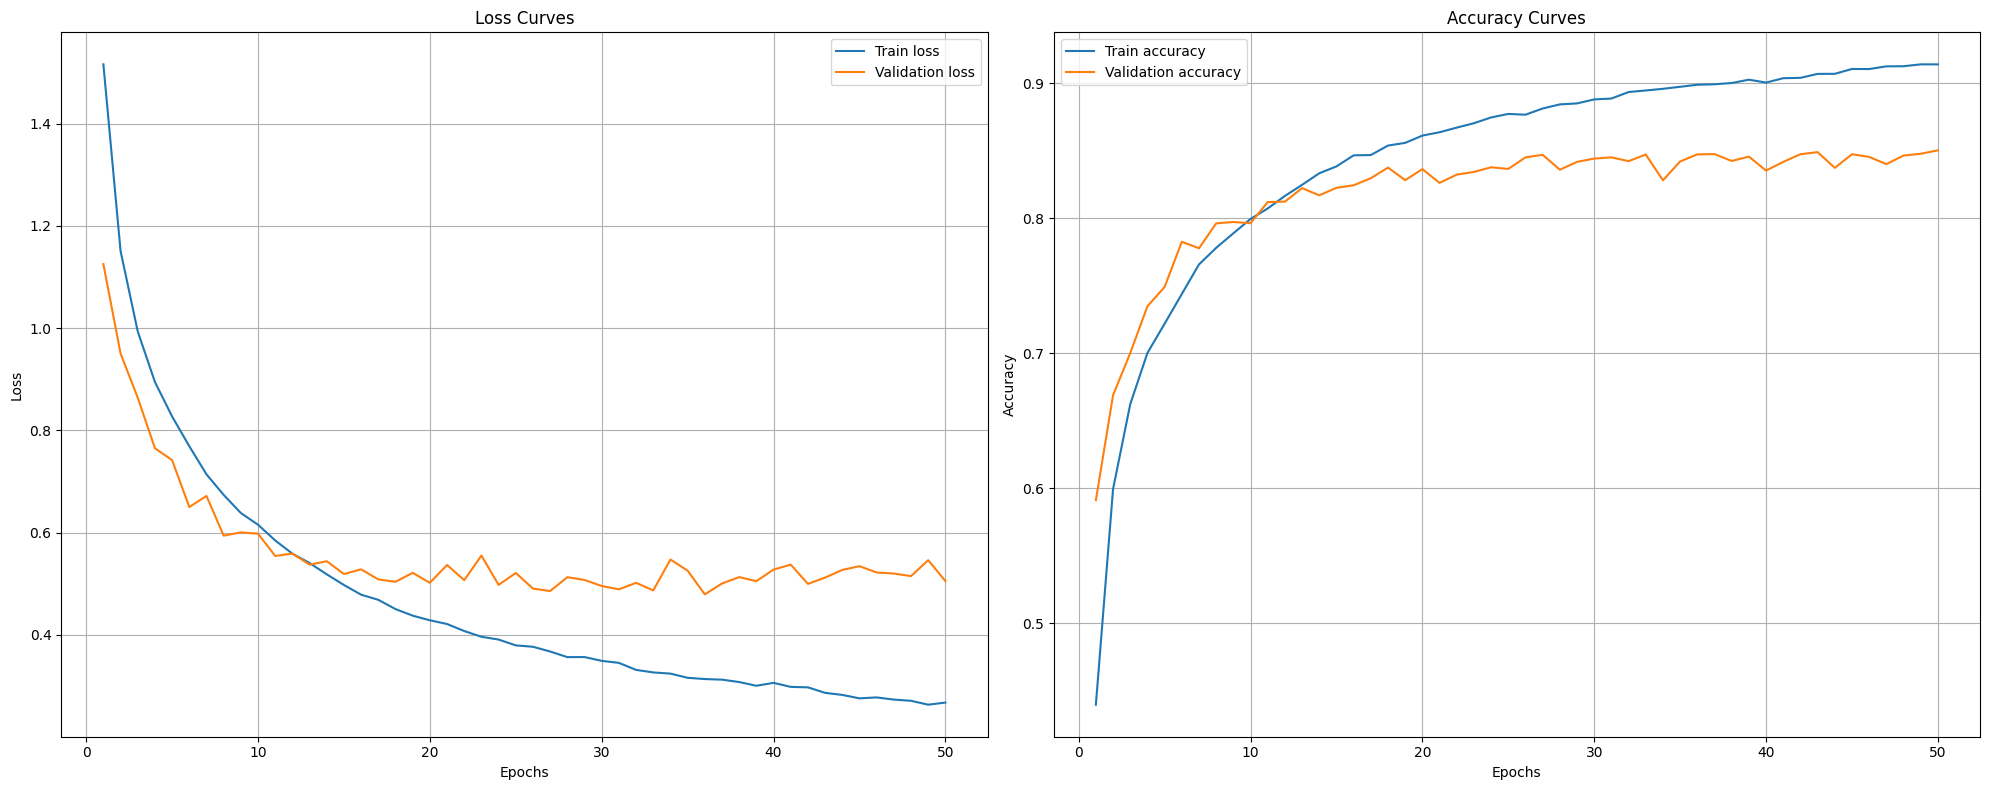

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Loss plot
ax1.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
ax1.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title("Loss Curves")
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(np.arange(1, no_epochs+1), train_acc, label="Train accuracy")
ax2.plot(np.arange(1, no_epochs+1), val_acc, label="Validation accuracy")
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title("Accuracy Curves")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Test accuracy: 0.838000


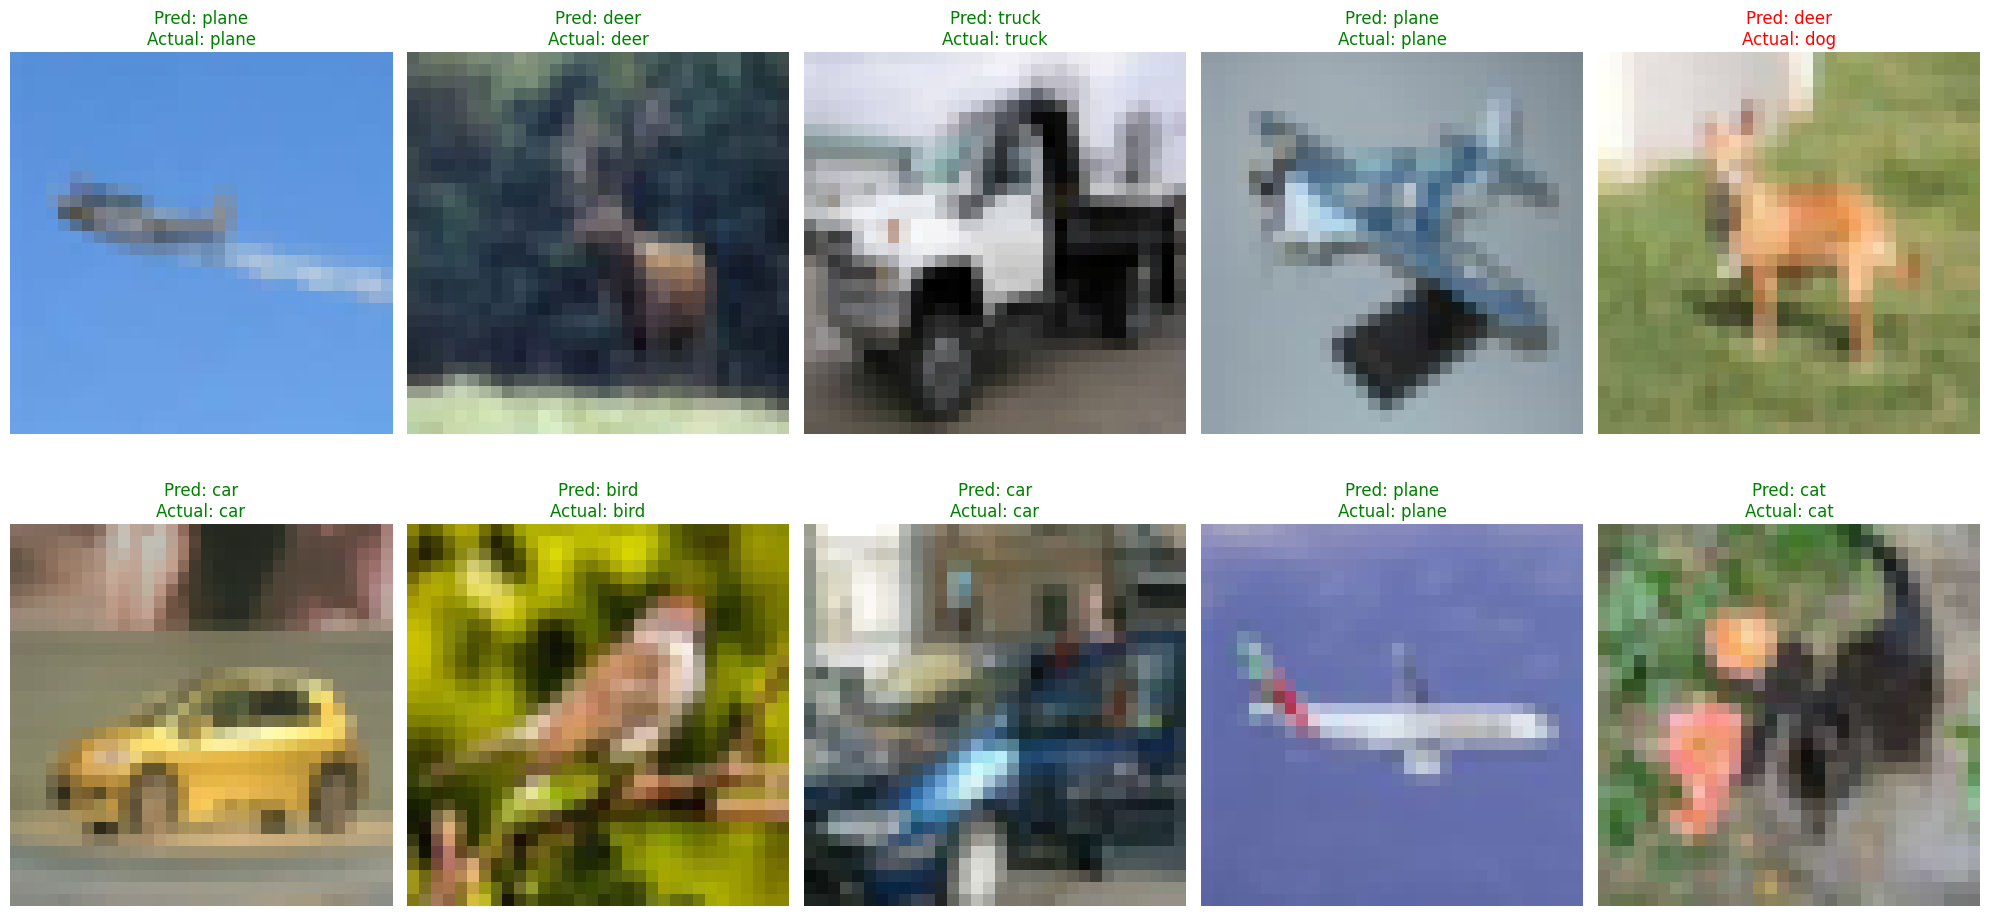

In [13]:
#Test model
model.load_state_dict(torch.load("model_cifar10.pth"))
model.eval()

test_correct = 0
total_test = 0
results = list()

with torch.no_grad():
    for itr, (image, label) in enumerate(test_dataloader):
        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()

        pred = model(image)
        _, predicted = torch.max(pred.data, 1)
        total_test += label.size(0)
        test_correct += (predicted == label).sum().item()

        if len(results) < 10:
            for i in range(min(len(image), 10 - len(results))):
                results.append((image[i].cpu(), predicted[i].cpu(), label[i].cpu()))

test_accuracy = test_correct / total_test
print(f'Test accuracy: {test_accuracy:.6f}')

# Visualize test results
fig = plt.figure(figsize=(20, 10))
for i in range(min(10, len(results))):
    img_tensor = results[i][0]
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    img_tensor = img_tensor * std + mean
    img_tensor = torch.clamp(img_tensor, 0, 1)

    img = transforms.ToPILImage()(img_tensor)
    fig.add_subplot(2, 5, i+1)

    predicted_class = classes[results[i][1].item()]
    actual_class = classes[results[i][2].item()]
    color = 'green' if predicted_class == actual_class else 'red'

    plt.title(f"Pred: {predicted_class}\nActual: {actual_class}", color=color)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()